# Time Series Forecasting for Companies
>CAP5610 Project

Project Author
- Juanita Ramirez



**Prerequisites**
- This Google Collab is writen in Python, and some of the packages and characteristics of python were applied in particular: Object Oriented Programing when creating a Window Generator Class, DataFrame manipulation and Multi - indexing with Pandas.
- This project is aiming to realize time series forecasting for companies, the following algorithms were used:
  - Lasso
  - Ridge
  - 1d CNN
  - Neural Network


## Section 1:

**Dataset**

Data from the Forbes ranking:  "Global 2000" will be used in this project, this dataset contains the company name and country and financial information regarding the company as Sales, Profit, Assets, and Market Value. This ranking has been published every year since 2003 and gives valuable insight into the world's largest public companies.


In this Project, the rankings from 2008 to 2023 were found at: https://data.world/aroissues/forbes-global-2000-2008-2019/workspace/data-dictionary . Then all the rankings were merged on the columns Company, Industry, and Country; obtaining the dataframe: `merged_df_cleaned`, for more information refer to: `Data_Merging.ipynb`.




In [1]:
#Libraries
import torch
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import keras
%matplotlib inline
from keras import layers
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import linear_model as lm
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor as RFR

In [72]:
## Reading Data Set

# from google.colab import drive  ##My excel files are in drive
# drive.mount('/content/drive/')
# %cd /content/drive/My Drive/Machine Learning - Project/DATA/

#Merged Dataset

# merged_df=pd.read_excel('merged_df.xlsx')
# ranking_num=pd.read_excel('ranking_num.xlsx')

merged_df_cleaned=pd.read_excel('merged_df_cleaned.xlsx')
merged_df_cleaned.shape


(385, 83)

In [74]:
#Descriptive Statistics
merged_df_cleaned.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rank_nr_2008,385.0,706.124675,507.225880,1.0,287.0,615.0,1070.0,1965.0
Sales_2008,385.0,20084.363636,28344.304573,50.0,4840.0,11280.0,21890.0,203970.0
Profits_2008,385.0,1869.012987,2923.589415,-700.0,380.0,810.0,1860.0,19130.0
Assets_2008,385.0,98629.558442,268452.074511,150.0,13450.0,24690.0,56130.0,2494410.0
Market_Value_2008,385.0,28631.194805,45065.083399,750.0,7500.0,14190.0,30360.0,546140.0
...,...,...,...,...,...,...,...,...
Rank_nr_2023,385.0,732.584416,517.414932,6.0,296.0,642.0,1080.0,1946.0
Sales_2023,385.0,32501.259740,48785.691640,-109991.0,9997.0,17869.0,35841.0,457405.0
Profits_2023,385.0,3209.244935,7765.341152,-22819.0,596.6,1389.5,3145.0,94321.0
Assets_2023,385.0,194719.493506,463496.001284,7527.0,27789.0,55700.0,133637.0,4421763.0


In [75]:
merged_df_cleaned.head()

,Company,Industry,Country,Rank_nr_2008,Sales_2008,Profits_2008,Assets_2008,Market_Value_2008,Rank_nr_2009,Sales_2009,...,Rank_nr_2022,Sales_2022,Profits_2022,Assets_2022,Market_Value_2022,Rank_nr_2023,Sales_2023,Profits_2023,Assets_2023,Market_Value_2023
0,HSBC Holdings,Banking,United Kingdom,1,146500.0,19130.0,2348980.0,180810.0,6,142050.0,...,38,59326,12577.5,2957939,135300,20,73976,22188.6,2989696,151187
1,Bank of America,Banking,United States,3,119190.0,14980.0,1715750.0,176530.0,38,113110.0,...,9,96826,30995.0,3238223,303102,6,133841,28622.0,3194657,220825
2,Toyota Motor,Consumer Durables,Japan,8,203800.0,13990.0,276380.0,175080.0,3,263420.0,...,10,281746,28154.4,552456,237726,13,270487,18497.4,542503,188198
3,Berkshire Hathaway,Diversified Financials,United States,10,118250.0,13210.0,273160.0,216650.0,19,107790.0,...,1,276094,89795.0,958784,741476,338,302089,-22819.0,948452,707207
4,BNP Paribas,Banking,France,13,116160.0,10710.0,2494410.0,81900.0,29,107960.0,...,39,127425,9848.3,2995890,68763,33,99466,10108.3,2845690,78591


**Reshaping**

Time series data needs to be in the correct format, each time corresponds to a row and each column is the interested variable tracked over time.
For this merged dataset, we have another dimension which is 'Company', then a multi-index data frame was chosen as the final form of the data.



In [76]:
# @title Sales, Profit, Assets and Market Value variables were separated into individual data frames.
years = list(range(2008, 2024, 1))

#Profit
Profits_Cols = ['Company'] + list('Profits_' + str(x) for x in years)
Profits_clean=merged_df_cleaned.loc[:, Profits_Cols]
Profits_clean=Profits_clean.set_index('Company').T

#Assets
Assets_Cols = ['Company'] + list('Assets_' + str(x) for x in years)
Assets_clean=merged_df_cleaned.loc[:, Assets_Cols]
Assets_clean=Assets_clean.set_index('Company').T

#Market Value
Market_Value_Cols = ['Company'] + list('Market_Value_' + str(x) for x in years)
Market_Value_clean=merged_df_cleaned.loc[:, Market_Value_Cols]
Market_Value_clean=Market_Value_clean.set_index('Company').T

#Sales
Sales_Cols = ['Company'] + list('Sales_' + str(x) for x in years)
Sales_clean=merged_df_cleaned.loc[:, Sales_Cols]
Sales_clean=Sales_clean.set_index('Company').T
Sales_clean['Year']=years
print("Sales Data Frame:")
print("Shape:",Sales_clean.shape)
Sales_clean.head()

Sales Data Frame:
Shape: (16, 386)


Company,HSBC Holdings,Bank of America,Toyota Motor,Berkshire Hathaway,BNP Paribas,Allianz,Chevron,AXA Group,ConocoPhillips,Goldman Sachs Group,...,Central Bank of India,Mizrahi Tefahot Bank,Basler Kantonalbank,Bank Negara Indonesia,IntercontinentalExchange,Tencent Holdings,CarMax,Thai Beverage,Jeronimo Martins,Year
Sales_2008,146500.0,119190.0,203800.0,118250.0,116160.0,139120.0,203970.0,151700.0,171500.0,87970.0,...,1580.0,1290.0,850.0,1980.0,570.0,360.0,8040.0,3370.0,5810.0,2008
Sales_2009,142050.0,113110.0,263420.0,107790.0,107960.0,127240.0,255110.0,156950.0,225420.0,53580.0,...,2220.0,1550.0,1080.0,2010.0,810.0,520.0,7550.0,3050.0,7810.0,2009
Sales_2010,103740.0,150450.0,210840.0,112490.0,101060.0,130060.0,159290.0,145860.0,136020.0,51670.0,...,2250.0,1520.0,1040.0,2470.0,990.0,1050.0,7110.0,3240.0,9600.0,2010
Sales_2011,103251.0,134194.0,202775.0,136185.0,130388.0,142875.0,189607.0,162369.0,175752.0,45967.0,...,3083.0,1727.0,970.0,2472.0,1150.0,2981.0,8556.0,4036.0,11635.0,2011
Sales_2012,102021.0,115074.0,228494.0,143688.0,119003.0,134441.0,236286.0,132813.0,230859.0,36793.0,...,3707.0,1504.0,1060.0,3074.0,1327.0,4527.0,9780.0,4188.0,12744.0,2012


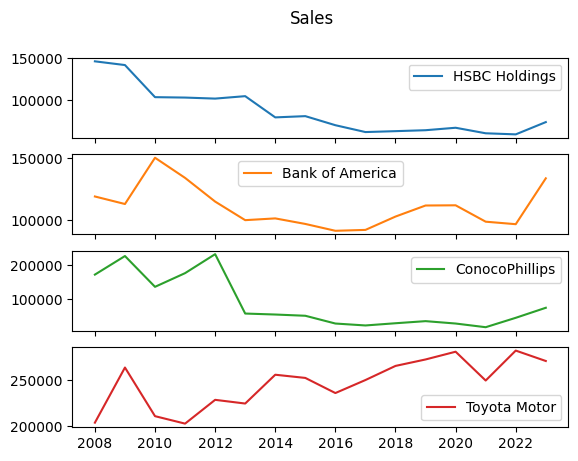

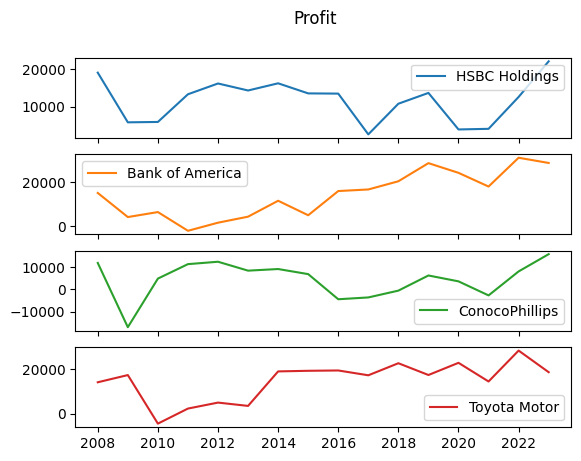

In [77]:
plot_cols = ['HSBC Holdings', 'Bank of America','ConocoPhillips','Toyota Motor']
plot_features = Sales_clean[plot_cols]
plot_features.index = years
_ =plot_features.plot(subplots=True, title='Sales')

plot_features = Profits_clean[plot_cols]
plot_features.index = years
_ =plot_features.plot(subplots=True, title='Profit')


In [78]:
#@title Final Cleaned Dataset: Desired Columns, Multi Indexed and Sorted
##Melt the dataframes (single column)
Profits_cm=pd.melt(Profits_clean,value_name='Profits')
Assets_cm=pd.melt(Assets_clean,value_name='Assets')
Market_value_cm=pd.melt(Market_Value_clean,value_name='Market Value')

# #initializing dataframe with column Sales and adding remaining columns
df_cleaned = pd.melt(Sales_clean,id_vars=['Year'],value_name='Sales')
df_cleaned['Profit']=Profits_cm['Profits']
df_cleaned['Assets']=Assets_cm['Assets']
df_cleaned['Market Value']= Market_value_cm['Market Value']

# Change company to number
unique_company = df_cleaned['Company'].unique()
company_idx={company : i for i, company in enumerate(unique_company)}
df_cleaned['Company']=df_cleaned['Company'].map(company_idx)

#Multi - Index sorted (company, year)
df_cleaned=df_cleaned.set_index(['Company','Year'])
df_cleaned= df_cleaned.sort_index()
df_cleaned.head()

Sales   Profit     Assets  Market Value
Company Year                                            
0       2008  146500.0  19130.0  2348980.0      180810.0
        2009  142050.0   5730.0  2520450.0       85040.0
        2010  103740.0   5830.0  2355830.0      178270.0
        2011  103251.0  13302.7  2467940.0      186472.0
        2012  102021.0  16209.4  2549994.0      164312.0

## Section 2 - Ridge and Lasso Regression

In this section, Lasso and Ridge Regression will be estimated and compared based on mean squared error, note that time series forecasting is not performed in this section, Market Value will be estimated based on Sales, Profits, and Assets.




In [9]:
#Standardize Data Function
standardize = lambda data,mu,std : (data-mu)/std


In [10]:
X = df_cleaned.loc[:, df_cleaned.columns != 'Market Value']
y = df_cleaned['Market Value']

# First Split: train and Test data (for non-neural network models)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [11]:
## standardize the data
x_mean=X_train1.mean()
x_std=X_train1.std()
y_mean=y_train1.mean()
y_std=y_train1.std()

X_train=standardize(X_train1,x_mean,x_std)
X_test=standardize(X_test1,x_mean,x_std)
y_train=standardize(y_train1,y_mean,y_mean)
y_test=standardize(y_test1,y_mean,y_mean)

##
scorer = make_scorer(mean_absolute_error, greater_is_better = False)
y_test_flattened = y_test.ravel()
val_performance = {} #Dictionaries to compare performance
test_performance = {}

**Ridge:**

In [12]:
#alphas_ridge = np.linspace(0.01,1000,2000) initial run
alphas_ridge = np.linspace(1000,1300,1000)

ridge_model = lm.Ridge(random_state=123)

grid_ridge = dict()
grid_ridge['alpha'] = alphas_ridge


In [13]:
# Running the Grid Search and saving the results
grid_2 = GridSearchCV(estimator = ridge_model, param_grid = grid_ridge, scoring = scorer, cv = 5)

# we fit with X_temp and y_temp since this split includes both the training and validation data.
ridge_results = grid_2.fit(X_train, y_train)

ridge_mean_mae = ridge_results.cv_results_['mean_test_score']

ridge_bscore = ridge_results.best_score_
ridge_bparam = ridge_results.best_params_

best_ridge = ridge_results.best_estimator_

The best score is: -0.5157998928070493 and it is obtained when alpha = 1147.7477477477478


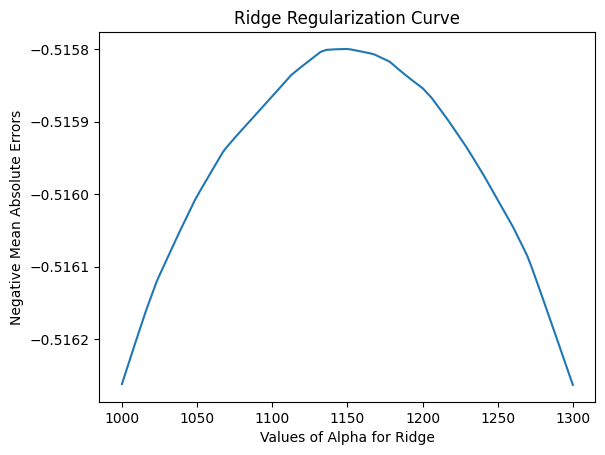

In [14]:
# We plot the regularization function for the lasso regression.
plt.plot(alphas_ridge, ridge_mean_mae)
plt.xlabel('Values of Alpha for Ridge')
plt.ylabel('Negative Mean Absolute Errors')
plt.title('Ridge Regularization Curve')

print('The best score is: ' + str(ridge_bscore) + ' and it is obtained when alpha = ' + str(ridge_bparam['alpha']))

The mean absolute error for the  Ridge Regression on the test is -0.2186483274490143


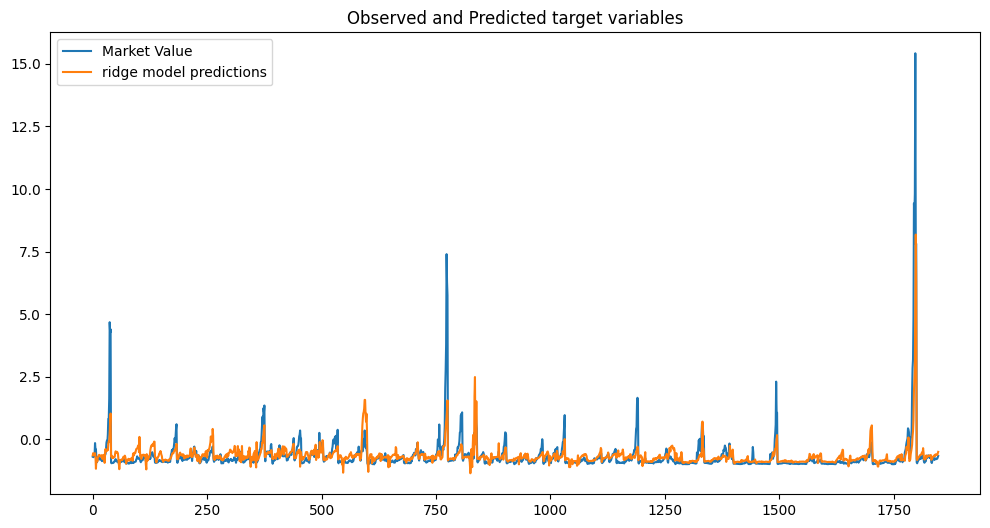

In [15]:
# We plot the results from the best ridge model against the target variable in the test set
y_pred_ridge = best_ridge.predict(X_test)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge) * (-1)

plt.figure(figsize = (12, 6))
plt.plot(y_test_flattened, label = 'Market Value')
plt.plot(y_pred_ridge, label = 'ridge model predictions')
plt.title('Observed and Predicted target variables')
plt.legend()

print('The mean absolute error for the  Ridge Regression on the test is ' + str(ridge_mae))

val_performance['Ridge'] = ridge_bscore
test_performance['Ridge'] = ridge_mae

**Lasso:**

In [16]:
# alphas_lasso = np.linspace(0.01, 5, 2000) -- initial Run
alphas_lasso = np.linspace(0.2, 1,100)
lasso_model = lm.Lasso()

grid_lasso = dict()
grid_lasso['alpha'] = alphas_lasso

In [17]:
# Running the Grid Search and saving the results
grid_1 = GridSearchCV(estimator = lasso_model, param_grid = grid_lasso, scoring = scorer, cv = 5)

# fit X_train and y_train
lasso_results = grid_1.fit(X_train, y_train)

lasso_mean_mae = lasso_results.cv_results_['mean_test_score']

lasso_bscore = lasso_results.best_score_
lasso_bparam = lasso_results.best_params_

best_lasso = lasso_results.best_estimator_

The best score is: -0.512283746058926 and it is obtained when alpha = 0.4101010101010101


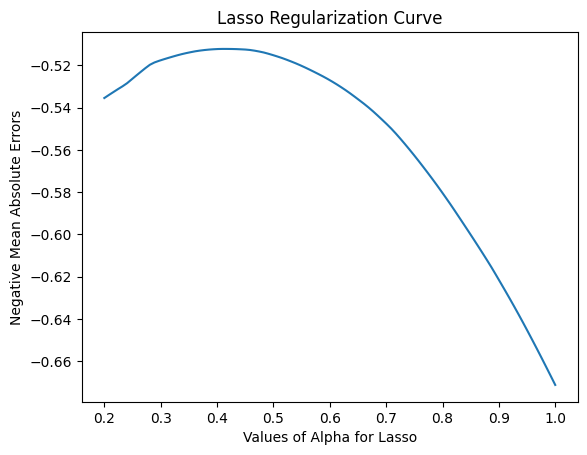

In [18]:
# We plot the regularization function for the lasso regression.
plt.plot(alphas_lasso, lasso_mean_mae)
plt.xlabel('Values of Alpha for Lasso')
plt.ylabel('Negative Mean Absolute Errors')
plt.title('Lasso Regularization Curve')

print('The best score is: ' + str(lasso_bscore) + ' and it is obtained when alpha = ' + str(lasso_bparam['alpha']))

The mean absolute error for the lasso model on the testing data is -0.2797393284399893


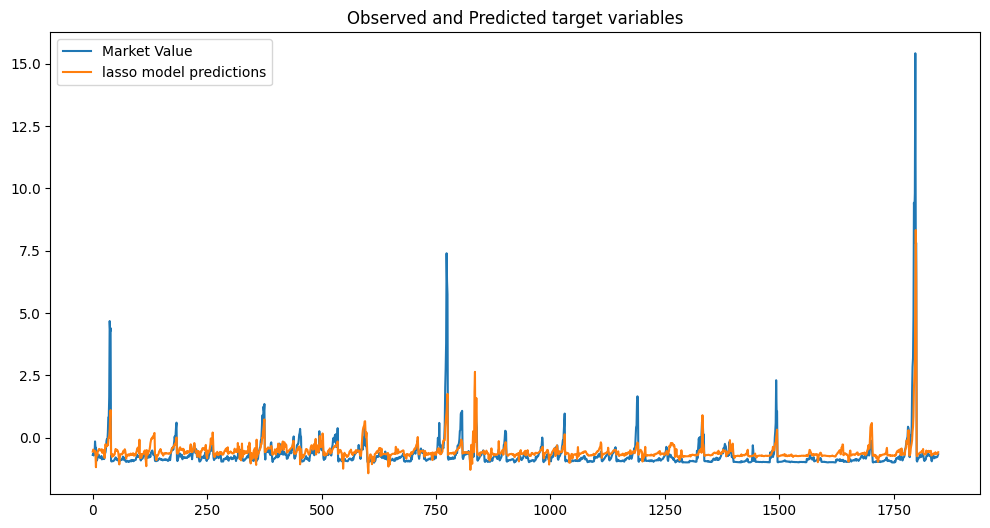

In [19]:
# We plot the results from the best lasso model against the target variable in the test set
y_pred_lasso = best_lasso.predict(X_test)
lasso_mae = mean_absolute_error(y_test, y_pred_lasso) * (-1)

plt.figure(figsize = (12, 6))
plt.plot(y_test_flattened, label = 'Market Value')
plt.plot(y_pred_lasso, label = 'lasso model predictions')
plt.title('Observed and Predicted target variables')
plt.legend()

print('The mean absolute error for the lasso model on the testing data is ' + str(lasso_mae))

val_performance['Lasso'] = lasso_bscore
test_performance['Lasso'] = lasso_mae
non_zero_lasso = np.count_nonzero(best_lasso.coef_)

In [20]:
val_performance

{'Ridge': -0.5157998928070493, 'Lasso': -0.512283746058926}

In [21]:
test_performance

{'Ridge': -0.2186483274490143, 'Lasso': -0.2797393284399893}

**Results:**The Ridge Regression performs better on the testing dataset. On the other hand, Ridge and Lasso have similar performances on the training dataset.


## Section 3: Time Series Forecasting
###3.1 Data Windowing


**Split Dataset:**

The dataset is split by companies instead of rows, the training dataset has 60% of the companies, and validation and testing datasets have 20% of  companies each. \
Each company has values from 2009 to 2023 for each of the financial columns, multi - indexing is used to sample the desired companies.


In [30]:
#@title Sample Indices

# Index slice for multi index
df=df_cleaned.copy()
idx=pd.IndexSlice

# Samples: 1
n=len(unique_company)
list1=np.array(range(n)) #All Company indices
sample_indices = np.random.choice(n, int(n*0.6), replace=False) #Train indices
# 2
list2= [x for x in list1 if x not in sample_indices]
n2=int(len(list2)*0.5)
sample_indices2 =np.random.choice(list2,n2,replace=False) # Val indices
# 3
sample_tot=np.concatenate((sample_indices,sample_indices2))
list3=[x for x in list1 if x not in sample_tot] # Test indices



In [31]:
#TRAIN, VAL AND TEST DATASETS
train = df_cleaned.loc[idx[sample_indices,:],:]
val= df_cleaned.loc[idx[sample_indices2,:],:]
test =df_cleaned.loc[idx[list3,:],:] #df.drop(sample_tot, level=0, axis=0, inplace=True).sort_index()

In [35]:
#STANDARDIZE
mu=train.mean()
std=train.std()
#Data
train_norm=standardize(train,mu,std)
val_norm=standardize(val,mu,std)
test_norm =standardize(test,mu,std)

**Window Generator Class:**

When working with time series Data, the objective is to predict the future with past data, thus is necessary to transform the data in pairs $(X_{past}, X_{future})$, we use the window generator class to create this tuples.

In this specific dataset, there are several samples (companies) of time series (2008-2023), In this case, we have to avoid overlapping the samples and put inputs from one company and targets from another.\
Example of overlapping error:
$$(CompanyA_{(2015-2023)},CompanyB_{2008})$$

*Important parameters:*

|Parameter|Description|
|---|---|
|input_width|How many points in the past I will use to make my prediction|
|label_width|How many targets I have (in the future)|
|shift|(Space between input and label) + label_width.  *Note: the label is inside the shift range*|
|sequence_stride=1|space between 1 sequence and another|
|sampling_rate=1| space between values inside the sequence|
|total_window_size|input_width+shift|
|||

Guide/Tutorial Used: https://www.tensorflow.org/tutorials/structured_data/time_series \





1. The function 'tf.keras.preprocessing.timeseries_dataset_from_array' was modified to accept num_seqs =  number of total sequences and start_positions = array indicating where to start the sequence.

This modified function is called 'timeseries_dataset_from_array_multi_index'

In [25]:
#@title ####timeseries_dataset_from_array_multi_index
def timeseries_dataset_from_array_multi_index(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None,
    num_seqs=None,
    start_positions=None,
):

    if start_index:
        if start_index < 0:
            raise ValueError(
                "`start_index` must be 0 or greater. Received: "
                f"start_index={start_index}"
            )
        if start_index >= len(data):
            raise ValueError(
                "`start_index` must be lower than the length of the "
                f"data. Received: start_index={start_index}, for data "
                f"of length {len(data)}"
            )
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError(
                "`end_index` must be higher than `start_index`. "
                f"Received: start_index={start_index}, and "
                f"end_index={end_index} "
            )
        if end_index >= len(data):
            raise ValueError(
                "`end_index` must be lower than the length of the "
                f"data. Received: end_index={end_index}, for data of "
                f"length {len(data)}"
            )
        if end_index <= 0:
            raise ValueError(
                "`end_index` must be higher than 0. "
                f"Received: end_index={end_index}"
            )

    # Validate strides
    if sampling_rate <= 0:
        raise ValueError(
            "`sampling_rate` must be higher than 0. Received: "
            f"sampling_rate={sampling_rate}"
        )
    if sampling_rate >= len(data):
        raise ValueError(
            "`sampling_rate` must be lower than the length of the "
            f"data. Received: sampling_rate={sampling_rate}, for data "
            f"of length {len(data)}"
        )
    if sequence_stride <= 0:
        raise ValueError(
            "`sequence_stride` must be higher than 0. Received: "
            f"sequence_stride={sequence_stride}"
        )
    if sequence_stride >= len(data):
        raise ValueError(
            "`sequence_stride` must be lower than the length of the "
            f"data. Received: sequence_stride={sequence_stride}, for "
            f"data of length {len(data)}"
        )

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)

    # Determine the lowest dtype to store start positions (to lower memory
    # usage).
    if num_seqs is None:
        num_seqs = end_index - start_index - (sequence_length - 1) * sampling_rate

    if targets is not None:
        num_seqs = min(num_seqs, len(targets))

    if num_seqs < 2147483647:
        index_dtype = "int32"
    else:
        index_dtype = "int64"

    # Generate start positions
    if start_positions is None:
        start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)

    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = tf.cast(sequence_length, dtype=index_dtype)
    sampling_rate = tf.cast(sampling_rate, dtype=index_dtype)

    positions_ds = tf.data.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = tf.data.Dataset.zip(
        (tf.data.Dataset.range(len(start_positions)), positions_ds)
    ).map(
        lambda i, positions: tf.range(
            positions[i],
            positions[i] + sequence_length * sampling_rate,
            sampling_rate,
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = tf.data.Dataset.zip(
            (tf.data.Dataset.range(len(start_positions)), positions_ds)
        ).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        target_ds = sequences_from_indices(
            targets, indices, start_index, end_index
        )
        dataset = tf.data.Dataset.zip((dataset, target_ds))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    if batch_size is not None:
        if shuffle:
            # Shuffle locally at each iteration
            dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
        dataset = dataset.batch(batch_size)
    else:
        if shuffle:
            dataset = dataset.shuffle(buffer_size=1024, seed=seed)
    return dataset


def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = tf.data.Dataset.from_tensors(array[start_index:end_index])
    dataset = tf.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
        lambda steps, inds: tf.gather(steps, inds),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return dataset

2. In the Window Generator Class the code is very similar to the guide, only two new attributes were added sequence_stride=1 and sampling_rate=1, used in the 'timeseries_dataset_from_array_multi_index' function.

In [26]:
#@title #### Window Generator Class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,sequence_stride=1,sampling_rate=1,
               train_df=train_norm, val_df=val_norm, test_df=test_norm,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)} # dictionary for the columns
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width #X width
    self.label_width = label_width # y width
    self.shift = shift #step? or offset?
    self.sequence_stride = sequence_stride
    self.sampling_rate = sampling_rate

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width) # Is useful to extract elements from those positions [0,input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice] #return indices of the input

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self): #_repr_ gives more information
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

3. The split method, creates tuples of inputs and lables.  (Same as the tutorial)

In [27]:
#@title ####Split
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

4. Calculate num_seqs and start_positions.

In [37]:
def num_seqs_per_sample(start_index,end_index,sampling_rate, sequence_length):
  nsps = end_index - start_index - (sequence_length - 1) * sampling_rate
  return nsps

def start_positions(sequence_stride,sampling_rate, sequence_length, n_sample, time):
  if sequence_length > time:
            raise ValueError(
                "`sequence_length` must be smaller than `time`, Overlapping samples error!."
            )
  nsps=num_seqs_per_sample(0,time,sampling_rate, sequence_length)
  n_total_sequences=nsps*n_sample
  if n_total_sequences < 2147483647:
      index_dtype = "int32"
  else:
      index_dtype = "int64"

  sp=np.empty(shape=(0,), dtype=index_dtype)
  for i in range(n_sample):
    sp_i=np.arange(0,nsps,sequence_stride,dtype=index_dtype)+(i*time)
    sp = np.append(sp, sp_i)
  return sp,n_total_sequences


5. Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs.

In [39]:
def make_dataset(self, data, n_sample, time):
  data = np.array(data, dtype=np.float32)
  sp,ns= start_positions(self.sequence_stride,self.sampling_rate, self.total_window_size, n_sample, time)
  if self.total_window_size > time:
          raise ValueError(
              "`total_window_size` must be smaller than `time`, Overlapping samples error!."
          )
  ds = timeseries_dataset_from_array_multi_index(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=self.sequence_stride,
      sampling_rate=self.sampling_rate,
      shuffle=True,
      batch_size=16,
      num_seqs=ns,  #NEW
      start_positions=sp, # NEW
      )

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [40]:
@property
def train(self):
  n_comp=self.train_df.index.get_level_values('Company').nunique()
  n_time=self.train_df.index.get_level_values('Year').nunique()
  return self.make_dataset(self.train_df,n_comp,n_time)

@property
def val(self):
  n_comp=self.val_df.index.get_level_values('Company').nunique()
  n_time=self.val_df.index.get_level_values('Year').nunique()
  return self.make_dataset(self.val_df,n_comp,n_time)

@property
def test(self):
  n_comp=self.test_df.index.get_level_values('Company').nunique()
  n_time=self.test_df.index.get_level_values('Year').nunique()
  return self.make_dataset(self.test_df,n_comp,n_time)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

## Example method

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.example = example


In [41]:
#@title ### Plot method for WindowGenerator Class
def plot(self, model=None, plot_col='Market Value', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [43]:
### My first window!
w1 = WindowGenerator(input_width=7, label_width=1, shift=1,label_columns=['Market Value']) #Example window
w1.train.element_spec


(TensorSpec(shape=(None, 7, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

### 3.2 Models

**First Model:** \

This model takes as input 4 years of data (Assets, Profits, Market Value and Sales) and  attempts to predict the market value of the company for the following year.

This model is a 1d CNN.



In [45]:
val_performance = {}
performance = {}

In [46]:
MAX_EPOCHS = 250

def compile_and_fit(model, window, patience=5):

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.RMSprop(),
    )


    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

In [92]:
CONV_WIDTH = 4

conv_window=WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1,label_columns=['Market Value'])

conv_model = keras.Sequential(
    [
        layers.Conv1D(filters=8, kernel_size=(CONV_WIDTH,), activation="relu"),
        layers.Dense(units=4, activation="relu"),
        layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model, conv_window)

val_performance['Conv1D'] = conv_model.evaluate(conv_window.val, verbose=0)
performance['Conv1D'] = conv_model.evaluate(conv_window.test)

Epoch 1/250
174/174 [==============================] - 2s 6ms/step - loss: 0.7142 - val_loss: 0.1352
Epoch 2/250
174/174 [==============================] - 1s 5ms/step - loss: 0.2151 - val_loss: 0.0799
Epoch 3/250
174/174 [==============================] - 1s 4ms/step - loss: 0.1581 - val_loss: 0.0658
Epoch 4/250
174/174 [==============================] - 1s 5ms/step - loss: 0.1432 - val_loss: 0.0617
Epoch 5/250
174/174 [==============================] - 2s 9ms/step - loss: 0.1339 - val_loss: 0.0614
Epoch 6/250
174/174 [==============================] - 1s 5ms/step - loss: 0.1292 - val_loss: 0.0563
Epoch 7/250
174/174 [==============================] - 1s 4ms/step - loss: 0.1231 - val_loss: 0.0543
Epoch 8/250
174/174 [==============================] - 1s 5ms/step - loss: 0.1198 - val_loss: 0.0526
Epoch 9/250
174/174 [==============================] - 1s 5ms/step - loss: 0.1140 - val_loss: 0.0517
Epoch 10/250
174/174 [==============================] - 1s 4ms/step - loss: 0.1115 - val_lo

In [81]:
conv_window.train.element_spec

(TensorSpec(shape=(None, 8, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

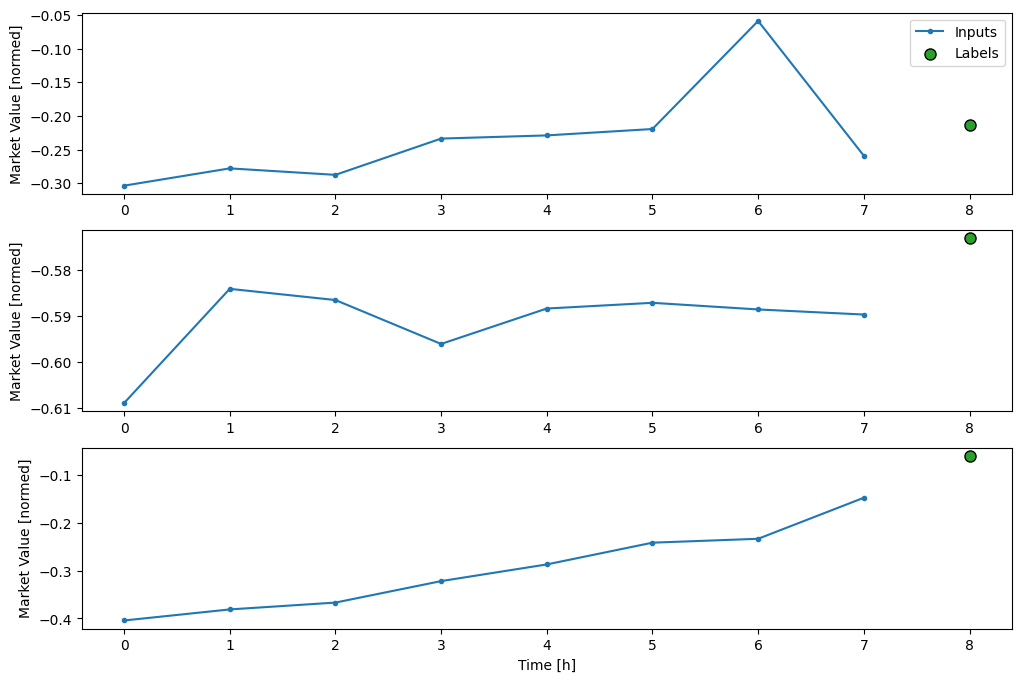

In [82]:
conv_window.plot()

**Second Model** \

This model takes as input 1 year of data (Market Value, Assets, Profits and Sales) and  attempts to predict the market value of the company for the following year.

This is a Neural Network Model.

In [83]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [84]:
column_indices = {name: i for i, name in enumerate(df.columns)}

single_step_window=WindowGenerator(input_width=1, label_width=1, shift=1,label_columns=['Market Value'])
baseline = Baseline(label_index=column_indices['Market Value'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

73/73 [==============================] - 0s 2ms/step - loss: 0.0391 - mean_absolute_error: 0.0944


In [85]:
wide_window = WindowGenerator(
    input_width=15, label_width=15, shift=1,
    label_columns=['Market Value'])

wide_window

Total window size: 16
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label column name(s): ['Market Value']

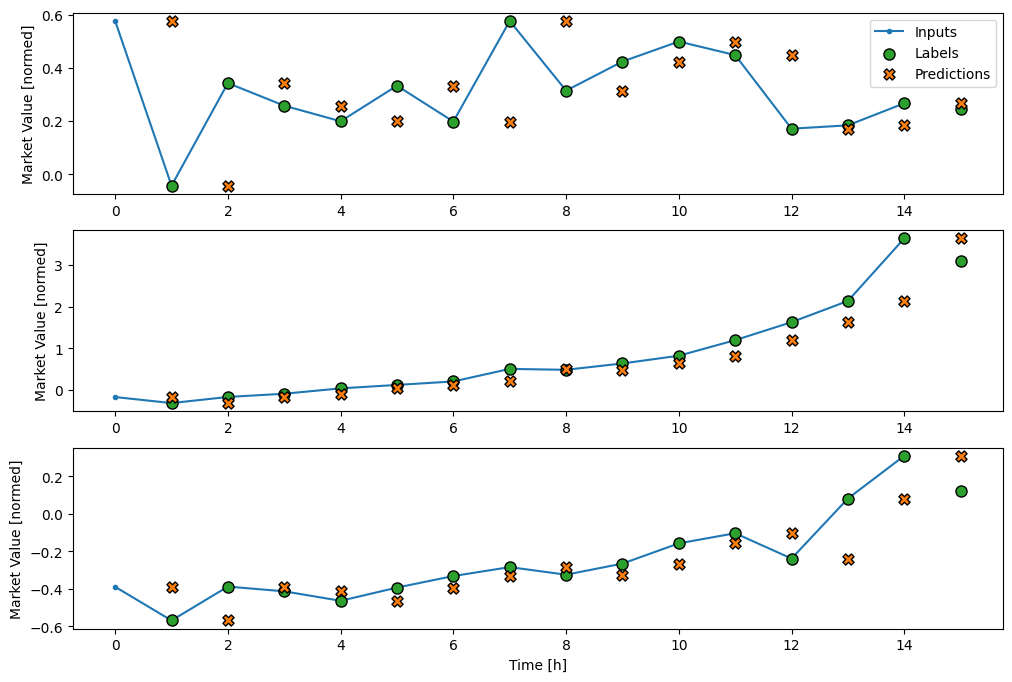

In [86]:
wide_window.plot(baseline)

**Results:**

In [93]:
val_performance

{'Conv1D': 0.03960290551185608,
 'Baseline': {'loss': 0.03905000537633896,
  'mean_absolute_error': 0.09439194947481155}}

In [94]:
performance

{'Conv1D': 0.7925792932510376,
 'Baseline': {'loss': 0.6104062795639038,
  'mean_absolute_error': 0.19875721633434296}}

The validation loss for both models is lower than the testing loss, this could indicate that the model is not generalizing well to unseen data (overfitting).